#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
%matplotlib inline

In [2]:
wiki = open('wiki_data.txt', encoding = 'utf-8').read().split('\n')
wiki

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

embeddings = svd.components_.T

id2word = cv.get_feature_names()
word2id = {word:i for i,word in enumerate(id2word)}


In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [morph.parse(token)[0].normal_form for token in tokens] #lemmatizing
    return tokens

vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
        
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [5]:
list(vocab.keys())

['новостройка',
 'нижегородский',
 'область)############новостро́йка',
 '—',
 'сельский',
 'посёлок',
 'в',
 'дивеевский',
 'район',
 'область',
 'входить',
 'состав',
 'сатисский',
 'сельсовета.############посёлок',
 'расположить',
 '12,5',
 'километр',
 'к',
 'юг',
 'от',
 'село',
 'дивеево',
 'и',
 '1',
 'запасть',
 'город',
 'саров',
 'на',
 'право',
 'берег',
 'река',
 'вичкинза',
 'правый',
 'приток',
 'сатис',
 'окружить',
 'смешанный',
 'леса',
 'соединить',
 'асфальтовый',
 'дорогой',
 'с',
 'цыгановка',
 '1,5',
 'грунтовый',
 'просёлочный',
 'дорога',
 '3,5',
 'название',
 'являться',
 'сугубо',
 'официальный',
 'местный',
 'население',
 'использовать',
 'исключительно',
 'альтернативный',
 'хитрый',
 'употребляться',
 'языковой',
 'оборот',
 '«…ный',
 'хитром»',
 'ранее',
 'песчаный',
 'известковый.############основать',
 '1920-ха',
 'год',
 'переселенец',
 'из',
 'соседний',
 'аламасовый',
 'нарышкино',
 'соответственно',
 '8',
 '14',
 'вознесенский',
 'районе).############

In [6]:
vocab_size = len(id2word)

total_words = 0
for w in list(vocab.keys()):
    if w in filtered_vocab:
        total_words += vocab[w]
probas = [vocab[w]/total_words for w in filtered_vocab ]


In [28]:
# skip gram
def gen_batches_sg(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(word2id[np.random.choice(
                    list(filtered_vocab), p=probas)])
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [29]:
# # cbow 
def gen_batches_cbow(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(word2id[np.random.choice(list(filtered_vocab), p=probas)])
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [33]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

sg_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
sg_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [35]:
sg_model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
3000/3000 [==============================] - 7702s 3s/step - loss: 0.6765 - accuracy: 0.5579 - val_loss: 0.6726 - val_accuracy: 0.5780
Epoch 2/2
3000/3000 [==============================] - 9367s 3s/step - loss: 0.6634 - accuracy: 0.5838 - val_loss: 0.6821 - val_accuracy: 0.5525


In [36]:
sg_embeddings = sg_model.layers[2].get_weights()[0]

In [37]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [38]:
most_similar('птица', sg_embeddings)

['птица',
 'подсемейство',
 'семейство',
 'растение',
 'овальный',
 'эвкалипт',
 'питаться',
 'ширина',
 'отверстие',
 'декоративный']

In [39]:
most_similar('церковь', sg_embeddings)

['церковь',
 'монастырь',
 'православный',
 'часовня',
 'собор',
 'здание',
 'возвести',
 'каменный',
 'митрополит',
 'синод']

In [40]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

cbow_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cbow_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [41]:
cbow_model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
3000/3000 [==============================] - 7731s 3s/step - loss: 0.5753 - accuracy: 0.6857 - val_loss: 0.5013 - val_accuracy: 0.7530
Epoch 2/2
3000/3000 [==============================] - 6955s 2s/step - loss: 0.4819 - accuracy: 0.7652 - val_loss: 0.4622 - val_accuracy: 0.7811


In [42]:
cbow_embeddings = cbow_model.layers[2].get_weights()[0]

In [43]:
most_similar('птица', cbow_embeddings)

['птица',
 'змей',
 'растение',
 'насекомое',
 'питаться',
 'животное',
 'цветок',
 'рыба',
 'млекопитающее',
 'гриб']

In [44]:
most_similar('церковь', cbow_embeddings)

['церковь',
 'храм',
 'собор',
 'икона',
 'часовня',
 'монастырь',
 'католический',
 'святой',
 'епархия',
 'свято-троицкий']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [46]:
import gensim

In [49]:
texts = [preprocess(text) for text in wiki]


In [50]:

%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs = 0,
                             negative =25,
                             vector_size=500,
                             min_count=20, 
                             max_vocab_size=20000,
                             window=6,
                             epochs=10,
                             sg =1,
                             sample = 1e-4,
                             ns_exponent = 0.55,
                             cbow_mean = 0)
                             

Wall time: 14min 36s


In [51]:
w2v.wv.most_similar('церковь')

[('храм', 0.6121646761894226),
 ('часовня', 0.5382782220840454),
 ('собор', 0.5348565578460693),
 ('освятить', 0.5320411324501038),
 ('православный', 0.5291754007339478),
 ('церковный', 0.5077150464057922),
 ('святитель', 0.4951942265033722),
 ('пресвятой', 0.4837229251861572),
 ('монастырь', 0.4777121841907501),
 ('кафедральный', 0.4749593436717987)]

In [53]:
w2v

In [55]:
%%time
ft = gensim.models.FastText(texts, min_n=5, max_n=10, hs = 0,
                             negative =25,
                             vector_size=500, 
                             min_count=20, 
                             max_vocab_size=20000,
                             window=6,
                             epochs=10,
                             sg =1,
                             sample = 1e-4,
                             ns_exponent = 0.55,
                             cbow_mean = 0)

Wall time: 24min 21s


In [56]:
ft.wv.most_similar('церковь')

[('храм', 0.6257538199424744),
 ('церковный', 0.5636438727378845),
 ('собор', 0.5621922612190247),
 ('освятить', 0.5493865013122559),
 ('православный', 0.546459972858429),
 ('часовня', 0.534898579120636),
 ('святитель', 0.5346284508705139),
 ('протоиерей', 0.514226496219635),
 ('пресвятой', 0.5038182735443115),
 ('святой', 0.5012832283973694)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [57]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [61]:
vocab2 = Counter()

for text in data['norm_text']:
    vocab2.update(text)
    
filtered_vocab2 = set()

for word in vocab2:
    if vocab2[word] > 5:
        filtered_vocab2.add(word)

len(filtered_vocab2)

6370

In [64]:
word2id2 = { 'PAD':0}

for word in filtered_vocab2:
    word2id2[word] = len(word2id2)
id2word2 = {i:word for word, i in word2id2.items()}

In [65]:
X = []

for tokens in data['norm_text']:
    ids = [word2id2[token] for token in tokens if token in word2id2]
    X.append(ids)

In [66]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [69]:
sg_weights = np.zeros((len(word2id2), 300))

for word, i in word2id2.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        sg_weights[i] = sg_embeddings[word2id[word]]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        sg_weights[i] = sg_embeddings[word2id['опрагпллирао']]

In [70]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=300, 
                                       trainable=False,
                                       weights=[sg_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 5s 7ms/step - loss: 0.6428 - accuracy: 0.6639 - val_loss: 0.6004 - val_accuracy: 0.6921
Epoch 2/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6162 - accuracy: 0.6637 - val_loss: 0.5876 - val_accuracy: 0.6921
Epoch 3/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6120 - accuracy: 0.6637 - val_loss: 0.5827 - val_accuracy: 0.6921
Epoch 4/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6090 - accuracy: 0.6637 - val_loss: 0.5791 - val_accuracy: 0.6921
Epoch 5/30
428/428 [==============================] - 3s 7ms/step - loss: 0.6062 - accuracy: 0.6637 - val_loss: 0.5759 - val_accuracy: 0.6921
Epoch 6/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6036 - accuracy: 0.6637 - val_loss: 0.5734 - val_accuracy: 0.6921
Epoch 7/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6011 - accuracy: 0.6637 - val_loss: 0.5696 - val_accuracy: 0.6921
Epoch 

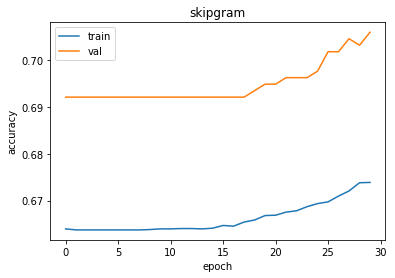

In [72]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('skipgram')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
cbow_weights = np.zeros((len(word2id2), 300))

for word, i in word2id2.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        cbow_weights[i] = cbow_embeddings[word2id[word]]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        cbow_weights[i] = cbow_embeddings[word2id['опрагпллирао']]

In [75]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=300, 
                                       trainable=False,
                                       weights=[cbow_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 7ms/step - loss: 0.6396 - accuracy: 0.6614 - val_loss: 0.5951 - val_accuracy: 0.6921
Epoch 2/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6124 - accuracy: 0.6637 - val_loss: 0.5815 - val_accuracy: 0.6921
Epoch 3/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6053 - accuracy: 0.6637 - val_loss: 0.5742 - val_accuracy: 0.6921
Epoch 4/30
428/428 [==============================] - 3s 6ms/step - loss: 0.5992 - accuracy: 0.6637 - val_loss: 0.5675 - val_accuracy: 0.6921
Epoch 5/30
428/428 [==============================] - 3s 6ms/step - loss: 0.5936 - accuracy: 0.6637 - val_loss: 0.5619 - val_accuracy: 0.6921
Epoch 6/30
428/428 [==============================] - 3s 7ms/step - loss: 0.5884 - accuracy: 0.6637 - val_loss: 0.5562 - val_accuracy: 0.6921
Epoch 7/30
428/428 [==============================] - 3s 6ms/step - loss: 0.5837 - accuracy: 0.6637 - val_loss: 0.5518 - val_accuracy: 0.6921
Epoch 

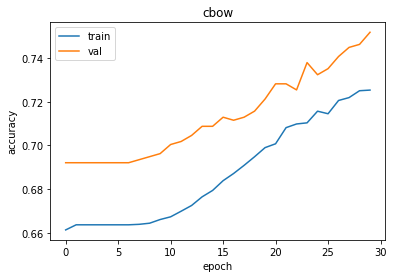

In [77]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('cbow')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [79]:
w2v_weights = np.zeros((len(word2id2), 500))

for word, i in word2id2.items():

    if word == 'PAD':
        continue

    try:
        w2v_weights[i] = w2v.wv[word]
    
    except KeyError:
        continue
        w2v_weights[i] = w2v.wv['опрагпллирао']

In [82]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=500, 
                                       trainable=False,
                                       weights=[w2v_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 5s 9ms/step - loss: 0.6265 - accuracy: 0.6601 - val_loss: 0.5806 - val_accuracy: 0.6921
Epoch 2/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6026 - accuracy: 0.6637 - val_loss: 0.5682 - val_accuracy: 0.6921
Epoch 3/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5917 - accuracy: 0.6644 - val_loss: 0.5543 - val_accuracy: 0.6921
Epoch 4/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5823 - accuracy: 0.6680 - val_loss: 0.5474 - val_accuracy: 0.7032
Epoch 5/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5742 - accuracy: 0.6760 - val_loss: 0.5397 - val_accuracy: 0.7129
Epoch 6/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5670 - accuracy: 0.6871 - val_loss: 0.5327 - val_accuracy: 0.7171
Epoch 7/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5608 - accuracy: 0.6959 - val_loss: 0.5277 - val_accuracy: 0.7226
Epoch 

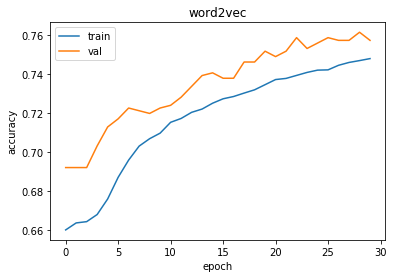

In [84]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('word2vec')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [86]:
ft_weights = np.zeros((len(word2id2), 500))

for word, i in word2id2.items():

    if word == 'PAD':
        continue

    try:
        ft_weights[i] = ft.wv[word]
    
    except KeyError:
        continue
        ft_weights[i] = ft.wv['опрагпллирао']

In [89]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=500, 
                                       trainable=False,
                                       weights=[ft_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [90]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 5s 9ms/step - loss: 0.6247 - accuracy: 0.6634 - val_loss: 0.5796 - val_accuracy: 0.6921
Epoch 2/30
428/428 [==============================] - 3s 8ms/step - loss: 0.6045 - accuracy: 0.6637 - val_loss: 0.5679 - val_accuracy: 0.6921
Epoch 3/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5941 - accuracy: 0.6642 - val_loss: 0.5603 - val_accuracy: 0.6949
Epoch 4/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5852 - accuracy: 0.6677 - val_loss: 0.5505 - val_accuracy: 0.7018
Epoch 5/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5773 - accuracy: 0.6738 - val_loss: 0.5412 - val_accuracy: 0.7087
Epoch 6/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5705 - accuracy: 0.6842 - val_loss: 0.5354 - val_accuracy: 0.7143
Epoch 7/30
428/428 [==============================] - 3s 8ms/step - loss: 0.5644 - accuracy: 0.6926 - val_loss: 0.5289 - val_accuracy: 0.7157
Epoch 

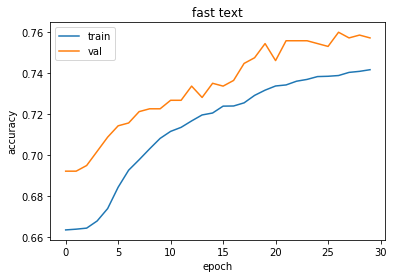

In [91]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('fast text')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [2]:

import gensim
model = gensim.models.KeyedVectors.load_word2vec_format(r"C:\Users\Светлана\ruscorpora\ruscorpora_mean_hs.model.bin", binary=True)

In [16]:
from pymystem3 import Mystem
m = Mystem()

def normalize_mystem(text):
    m = Mystem()

    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [9]:
import wget

In [10]:
url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'
wget.download(url, 'ru-rnc.map.txt')


100% [................................................................................] 4093 / 4093

'ru-rnc.map.txt'

In [11]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [5]:
data = pd.read_csv('labeled.csv')

In [7]:
data

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\r\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [19]:
mystem_data = []
for comment in data['comment']:
    stem = normalize_mystem(comment)
    mystem_data.append(stem)

RuntimeError: Problem has been occured. Current state:
text:
b'\xd0\x9d\xd1\x83 \xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8 \xd1\x83\xd1\x81\xd0\xbf\xd0\xb5\xd0\xbb \xd0\xbd\xd0\xbe\xd1\x82\xd0\xb0\xd1\x80\xd0\xb8\xd0\xb0\xd0\xbb\xd1\x8c\xd0\xbd\xd1\x8b\xd0\xb9 \xd1\x81\xd0\xba\xd1\x80\xd0\xb8\xd0\xbd \xd1\x81\xd0\xb0\xd0\xb9\xd1\x82\xd0\xb0 \xd0\xb7\xd0\xb0\xd0\xb2\xd0\xb5\xd1\x80\xd0\xb8\xd1\x82\xd1\x8c - \xd1\x82\xd0\xbe\xd0\xb3\xd0\xb4\xd0\xb0 \xd0\xb4\xd0\xb0, \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82 \xd0\xb4\xd0\xb0\xd0\xb6\xd0\xb5 \xd0\xbf\xd1\x80\xd0\xbe\xd0\xba\xd0\xb0\xd1\x82\xd0\xb8\xd1\x82\xd1\x8c... \xd0\x9d\xd0\xbe \xd1\x82\xd0\xb0\xd0\xbc 99 \xd1\x81\xd0\xbd\xd0\xbe\xd1\x81\xd0\xba\xd0\xb0 \xd0\xb5\xd1\x81\xd1\x82\xd1\x8c \xd0\xbf\xd1\x80\xd0\xb8\xd0\xbd\xd1\x8f\xd1\x82\xd0\xb0\xd1\x8f \xd0\xb2 \xd0\xb4\xd1\x83\xd1\x85\xd0\xb5 \xd0\xbf\xd1\x80\xd0\xb5\xd0\xb4\xd0\xbe\xd1\x81\xd1\x82\xd0\xb0\xd0\xb2\xd0\xbb\xd0\xb5\xd0\xbd\xd0\xbd\xd1\x8b\xd0\xb9 \xd0\xbd\xd0\xb0 \xd1\x81\xd0\xb0\xd0\xb9\xd1\x82\xd0\xb5 \xd1\x82\xd0\xbe\xd0\xb2\xd0\xb0\xd1\x80 \xd0\xbd\xd0\xb5 \xd0\xbe\xd1\x82\xd1\x80\xd0\xb0\xd0\xb6\xd0\xb0\xd0\xb5\xd1\x82 \xd1\x82\xd0\xbe\xd1\x87\xd0\xbd\xd0\xbe\xd0\xb9 \xd0\xba\xd0\xb0\xd1\x80\xd1\x82\xd0\xb8\xd0\xbd\xd1\x8b \xd0\xb8 \xd0\xbc\xd0\xbe\xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb8'
out:
b''

In [18]:
arr = []
for comment in t['comment']:
    print(normalize_mystem(comment))

['верблюд_NOUN', 'то_PART', 'за_ADP', 'что_PRON', 'дебил_NOUN', 'бл_X']
['хохол_NOUN', 'это_PART', 'отдушина_NOUN', 'затюканый_ADJ', 'россиянин_NOUN', 'мол_PART', 'вон_PART', 'а_SCONJ', 'у_ADP', 'хохлов_NOUN', 'еще_ADV', 'плохо_ADV', 'если_SCONJ', 'бы_PART', 'хохлов_NOUN', 'не_PART', 'быть_VERB', 'кисель_NOUN', 'они_PRON', 'бы_PART', 'придумывать_VERB']
['собака_NOUN', 'собачий_ADJ', 'смерть_NOUN']
['страница_NOUN', 'обновлять_VERB', 'дебил_NOUN', 'это_PRON', 'тоже_PART', 'не_PART', 'оскорбление_NOUN', 'а_SCONJ', 'доказывать_VERB', 'факт_NOUN', 'не_PART', 'дебил_NOUN', 'про_ADP', 'себя_PRON', 'во_ADP', 'множественный_ADJ', 'число_NOUN', 'писать_VERB', 'не_PART', 'быть_VERB', 'или_SCONJ', 'мы_PRON', 'в_ADP', 'ты_PRON', 'верить_VERB', 'это_PART', 'ты_PRON', 'и_SCONJ', 'твой_DET', 'воображаемый_ADJ', 'друг_NOUN']
['ты_PRON', 'не_PART', 'убеждать_VERB', 'страничный_ADJ', 'пдф_X', 'в_ADP', 'то_PRON', 'что_SCONJ', 'скрипалый_ADJ', 'отравлять_VERB', 'россия_NOUN', 'анализировать_VERB', 'и_SCO

['да_SCONJ', 'какой_DET', 'агрессия_NOUN', 'ты_PRON', 'ткнуть_VERB', 'в_ADP', 'твой_DET', 'же_PART', 'дерьмо_NOUN', 'обтекать_VERB', 'это_PART', 'я_PRON', 'без_ADP', 'отрицательный_ADJ', 'эмоция_NOUN', 'просто_PART', 'факт_NOUN']
['что_PRON', 'ты_PRON', 'иметь_VERB', 'против_ADP', 'кремль_NOUN', 'холоп_NOUN', 'заморский_ADJ', 'барин_NOUN']
['ох_INTJ', 'вау_NOUN', 'а_SCONJ', 'какой_DET', 'сторона_NOUN', 'нож_NOUN', 'резать_VERB', 'не_PART', 'подсказывать_VERB', 'дебил_NOUN', 'хвастаться_VERB', 'рязанский_ADJ', 'ебло_NOUN', 'еще_ADV', 'и_SCONJ', 'гуглить_VERB', 'незнакомый_ADJ', 'словечко_NOUN', 'ну_PART', 'весь_DET', 'суть_NOUN', 'никто_PRON', 'не_PART', 'нужный_ADJ', 'селюк_NOUN', 'с_ADP', 'никто_PRON', 'не_PART', 'нужный_ADJ', 'тред_NOUN']
['это_PRON', 'совсем_ADV', 'не_PART', 'смешно_ADV', 'но_SCONJ', 'урод_NOUN', 'мочь_VERB', 'поржать_VERB', 'и_SCONJ', 'они_PRON', 'даже_PART', 'не_PART', 'объяснять_VERB', 'что_SCONJ', 'они_PRON', 'урод_NOUN', 'они_PRON', 'приспосабливаться_VERB', 'с

['может_ADV', 'и_SCONJ', 'старый_ADJ', 'мочь_VERB', 'и_SCONJ', 'маразматик_NOUN', 'про_ADP', 'то_PRON', 'писать_VERB', 'кириллица_NOUN', 'или_SCONJ', 'латинница_NOUN', 'вы_PRON', 'видный_ADJ', 'не_PART', 'спорить_VERB', 'но_SCONJ', 'как_ADV', 'задвигать_VERB', 'русский_ADJ', 'язык_NOUN', 'уже_ADV', 'видно_ADV', 'далеко_ADV', 'сказать_VERB', 'что_SCONJ', 'все_PRON', 'быть_VERB', 'только_PART', 'на_ADP', 'казахский_ADJ', 'и_SCONJ', 'внезапно_ADV', 'пол_NUM', 'страна_NOUN', 'оказываться_VERB', 'второй_ADJ', 'сорт_NOUN', 'я_PRON', 'надеяться_VERB', 'что_SCONJ', 'ошибаться_VERB', 'но_SCONJ', 'это_PRON', 'уже_ADV', 'проходить_VERB', 'в_ADP', 'другой_DET', 'страна_NOUN', 'азия_NOUN', 'прибалтика_NOUN', 'закавказье_NOUN', 'а_SCONJ', 'так_ADV', 'я_PRON', 'за_ADP', 'мир_NOUN', 'во_ADP', 'все_PRON', 'мир_NOUN', 'русский_ADJ', 'слон_NOUN', 'хороший_ADJ', 'друг_NOUN', 'казахский_ADJ', 'слон_NOUN']
['шизофазия_NOUN', 'речевой_ADJ', 'разорванность_NOUN', 'симптом_NOUN', 'психический_ADJ', 'расстройст

KeyboardInterrupt: 

In [22]:
data2 = data[:len(mystem_data)]
data2['mystem_data'] = mystem_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:

vocab_ru = Counter()

for text in data2.mystem_data:
    vocab_ru.update(text)
    
filtered_vocab_ru = set()

for word in vocab_ru:
    if vocab_ru[word] > 30:
        filtered_vocab_ru.add(word)
        
word2id_ru = { 'PAD':0}

for word in filtered_vocab_ru:
    word2id_ru[word] = len(word2id_ru)
id2word_ru = {i:word for word, i in word2id_ru.items()}
#data_sentences = []
X=[]
for tokens in data2.mystem_data:    
    ids = [word2id_ru[token] for token in tokens if token in word2id_ru]
    #data_sentences.append(ids)
    X.append(ids)


In [26]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data2.toxic.values

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)


In [28]:
weights_ru = np.zeros((len(word2id_ru), 300))

for word, i in word2id_ru.items():

    if word == 'PAD':
        continue

    try:
        weights_ru[i] = model[word]
    
    except KeyError:
        continue
        weights_ru[i] = model['опрагпллирао']


In [29]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_ru), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_ru])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
45/45 [==============================] - 2s 18ms/step - loss: 0.6921 - accuracy: 0.5742 - val_loss: 0.6916 - val_accuracy: 0.5570
Epoch 2/30
45/45 [==============================] - 0s 8ms/step - loss: 0.6901 - accuracy: 0.5749 - val_loss: 0.6902 - val_accuracy: 0.5570
Epoch 3/30
45/45 [==============================] - 0s 7ms/step - loss: 0.6884 - accuracy: 0.5749 - val_loss: 0.6892 - val_accuracy: 0.5570
Epoch 4/30
45/45 [==============================] - 0s 8ms/step - loss: 0.6872 - accuracy: 0.5749 - val_loss: 0.6885 - val_accuracy: 0.5570
Epoch 5/30
45/45 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.5749 - val_loss: 0.6879 - val_accuracy: 0.5570
Epoch 6/30
45/45 [==============================] - 0s 8ms/step - loss: 0.6853 - accuracy: 0.5749 - val_loss: 0.6874 - val_accuracy: 0.5570
Epoch 7/30
45/45 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.5749 - val_loss: 0.6871 - val_accuracy: 0.5570
Epoch 8/30
45/45 [=

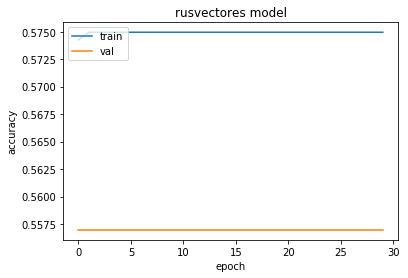

In [31]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('rusvectores model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()